In [3]:
import json
import pandas as pd

# Load the JSON data
with open('sr28.json') as f:
    data = json.load(f)

# Convert the data into a DataFrame
df = pd.json_normalize(data['foods'])

In [4]:
df

,description,nutrients,measures,nutrient_id,food_group.food_group_code,food_group.description
0,"[butter, salted]","[{'value': 0.85, 'units': 'g', 'name': 'protei...","[{'quantity': 1.0, 'unit': 'pat (1"" sq, 1/3"" h...",01001,0100,dairy and egg products
1,"[butter, whipped, with salt]","[{'value': 0.49, 'units': 'g', 'name': 'protei...","[{'quantity': 1.0, 'unit': 'pat (1"" sq, 1/3"" h...",01002,0100,dairy and egg products
2,"[butter oil, anhydrous]","[{'value': 0.28, 'units': 'g', 'name': 'protei...","[{'quantity': 1.0, 'unit': 'tbsp', 'weight': 1...",01003,0100,dairy and egg products
3,"[cheese, blue]","[{'value': 21.4, 'units': 'g', 'name': 'protei...","[{'quantity': 1.0, 'unit': 'oz', 'weight': 28....",01004,0100,dairy and egg products
4,"[cheese, brick]","[{'value': 23.24, 'units': 'g', 'name': 'prote...","[{'quantity': 1.0, 'unit': 'cup, diced', 'weig...",01005,0100,dairy and egg products
...,...,...,...,...,...,...
8784,"[fish, mackerel, salted]","[{'value': 18.5, 'units': 'g', 'name': 'protei...","[{'quantity': 1.0, 'unit': 'piece (5-1/2"" x 1-...",83110,1500,finfish and shellfish products
8785,"[mollusks, scallop, (bay and sea), cooked, ste...","[{'value': 20.54, 'units': 'g', 'name': 'prote...","[{'quantity': 3.0, 'unit': 'oz', 'weight': 85....",90240,1500,finfish and shellfish products
8786,"[syrup, cane]","[{'value': 0.0, 'units': 'g', 'name': 'protein...","[{'quantity': 1.0, 'unit': 'serving', 'weight'...",90480,1900,sweets
8787,"[mollusks, snail, raw]","[{'value': 16.1, 'units': 'g', 'name': 'protei...","[{'quantity': 3.0, 'unit': 'oz', 'weight': 85....",90560,1500,finfish and shellfish products


In [11]:
import json
import pandas as pd

# Load the JSON data
with open('sr28.json') as f:
    data = json.load(f)

# Convert the data into a DataFrame
df = pd.json_normalize(data['foods'])

# Convert description list to a space-separated string
df['description'] = df['description'].apply(' '.join)

# Convert nutrients list of dicts to individual columns
def nutrients_to_series(nutrients):
    return pd.Series({nutrient['name']: nutrient['value'] for nutrient in nutrients})

nutrients = df['nutrients'].apply(nutrients_to_series)
df = pd.concat([df.drop('nutrients', axis=1), nutrients], axis=1)

# Print the DataFrame
df = df[['description', 'proteins', 'fats', 'carbohydrates', 'calories']]

In [57]:
# JSON of proteins, fats, carbs, calories for each food item
df['answer'] = df.apply(lambda row: json.dumps({
    'proteins': row['proteins'],
    'fats': row['fats'],
    'carbohydrates': row['carbohydrates'],
    'calories': row['calories']
}), axis=1)

In [58]:
df.to_csv('sr28.csv', index=False)

In [14]:
import openai
import os
os.environ['OPENAI_API_KEY'] = "insert your key here"

In [25]:
test_samples = df.sample(250, random_state=1).reset_index(drop=True)

In [27]:
registry_path = os.path.join(os.getcwd(), "openai-evals/evals/registry")

In [28]:
os.path.exists(registry_path)

True

In [29]:
test_samples

,description,proteins,fats,carbohydrates,calories
0,mollusks scallop (bay and sea) cooked steamed,20.54,0.84,5.41,111.0
1,denny's spaghetti and meatballs,7.84,8.52,15.51,170.0
2,digiorno pizza cheese topping rising crust fro...,12.80,8.60,31.78,256.0
3,fast foods hamburger; single regular patty; wi...,13.30,10.18,29.57,263.0
4,cinnamon buns frosted (includes honey buns),4.45,26.61,48.60,452.0
...,...,...,...,...,...
245,pork fresh loin sirloin (chops or roasts) bone...,22.81,2.59,0.00,121.0
246,keebler zesta saltines original,8.20,9.00,76.10,418.0
247,pepperidge farm hamburger bun,0.01,3.71,50.00,278.0
248,babyfood fruit peaches strained,0.94,0.33,14.48,65.0


In [32]:
# Build the prompts using Chat format. We support converting Chat conversations to text for non-Chat models

def create_chat_prompt(item_description):
    sys_msg = "You are an expert nutritionist. You can provide nutrition information of any specific food item extremely accurately. You will be asked to provide values in grams for proteins, fats, carbohydrates and calories of 100g of a given item in JSON format."
    user_prompt = f"what is the nutrition information of 100g of {item_description}?" 
    return [
        {"role": "system", "content": sys_msg}, 
        {"role": "user", "content": user_prompt}
    ]

In [59]:
test_samples["input"] = test_samples.apply(lambda x: create_chat_prompt(x['description']), axis=1)

In [34]:
import yaml
from tqdm import tqdm

registry_yaml = {}

subject_path = os.path.join(registry_path, "data", "sr28")
os.makedirs(subject_path, exist_ok=True)

# Create test prompts and ideal completions
test_df = test_samples.copy()
test_df["input"] = test_df.input
test_df["ideal"] = test_df.answer
samples_path = os.path.join(subject_path, "samples.jsonl")     
test_df[["input", "ideal"]].to_json(samples_path, lines=True, orient="records")

In [38]:
registry_path

'/Users/vishhvak/Repos/tbsp/evals/openai-evals/evals/registry'

In [42]:
eval_id = f"sr28"

registry_yaml[eval_id] = {
    "id": f"{eval_id}.test.v1",
    "metrics": ["accuracy"]
}
registry_yaml[f"{eval_id}.test.v1"] = {
    "class": "evals.elsuite.basic.json_match:JsonMatch",
    "args": {
        "samples_jsonl": samples_path,
    }
}

with open(os.path.join(registry_path, "evals", "sr28.yaml"), "w") as f:
    yaml.dump(registry_yaml, f)

In [ ]:
!oaieval gpt-4-1106-preview sr28

/var/folders/t8/pj358_hn58n946vqrtpwy85r0000gn/T/ipykernel_72430/3578362934.py:7: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  events_df = pd.read_json("".join(lines), lines=True)


<Axes: title={'center': 'Correctness of generated answers'}, xlabel='Correctness', ylabel='Count'>

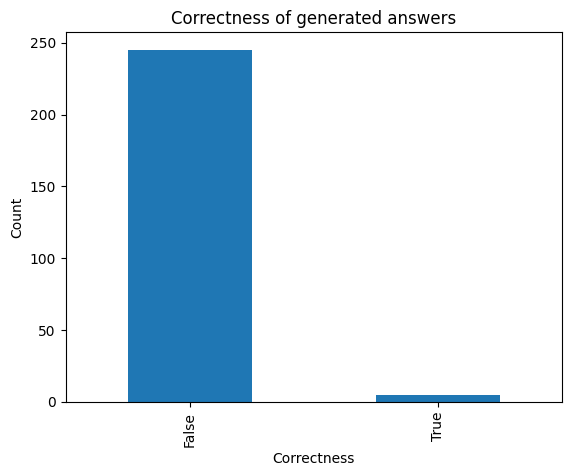

In [45]:
# How to process the log events generated by oaieval
import pandas as pd
events = "/tmp/evallogs/231227074317ODJYAUKC_gpt-4-1106-preview_sr28.jsonl"

with open(events, "r") as f:
    lines = f.readlines()[1:]
    events_df = pd.read_json("".join(lines), lines=True)

matches_df = events_df[events_df.type == "match"].reset_index(drop=True)
matches_df = matches_df.join(pd.json_normalize(matches_df.data))
matches_df.correct.value_counts().plot.bar(title="Correctness of generated answers", xlabel="Correctness", ylabel="Count")

In [50]:
df_res = matches_df[['data', 'correct']]

In [54]:
df_res.iloc[0].data

{'correct': False,
 'expected': '{"proteins": 33.26, "fats": 6.99, "carbohydrates": 0.0, "calories": 205.0}',
 'picked': []}

In [3]:
# Get Output Parser Instructions to Format Output as JSON from Langchain 

from langchain.llms import OpenAI
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field, validator

model = OpenAI(model_name="gpt-3.5-turbo-instruct", temperature=0.0, openai_api_key="insert your key here")

# Define your desired data structure.
class Nutrition(BaseModel):
    carbohydrates: float = Field(description="carbohydrates in grams")
    proteins: float = Field(description="proteins in grams")
    fats: float = Field(description="fats in grams")
    calories: float = Field(description="calories in kcal")
    

# Set up a parser + inject instructions into the prompt template.
parser = PydanticOutputParser(pydantic_object=Nutrition)

prompt = PromptTemplate(
    template="What is the nutrition information of 100g of {item_description}? \n{format_instructions}",
    input_variables=["item_description"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

# And a query intended to prompt a language model to populate the data structure.
prompt_and_model = prompt | model
output = prompt_and_model.invoke({"item_description": "banana"})
parser.invoke(output)

Nutrition(carbohydrates=23.1, proteins=1.1, fats=0.3, calories=89.0)

In [10]:
print(prompt.invoke({"item_description": "banana"}).text)

What is the nutrition information of 100g of banana? 
The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"carbohydrates": {"title": "Carbohydrates", "description": "carbohydrates in grams", "type": "number"}, "proteins": {"title": "Proteins", "description": "proteins in grams", "type": "number"}, "fats": {"title": "Fats", "description": "fats in grams", "type": "number"}, "calories": {"title": "Calories", "description": "calories in kcal", "type": "number"}}, "required": ["carbohydrates", "proteins", "fats", "calories"]}
```
